# Different segmentation workflows

This notebook walks you through the different segmentation workflows currently implemented in scPortrait using the same input example. Each segmentation workflow needs to be implemented in a seperate scPortrait project as the segmentation mask is the starting point for all further downstream steps.

## Overview of Segmentation Methods

| Segmentation Method | Segmentation Method Type | Description |
|---------------------|--------------------------|-------------|
| [WGA Segmentation](#wga-segmentation) | Classical segmentation method  | segments nuclei and matching cytosol masks of mono-nucleated cells using a combination of thresholding and watershed algorithms to detect individual segmentation masks. |
| [DAPI Segmentation](#dapi-segmentation) | Classical segmentation method |  segments nuclei using a thresholding approach. |
| [Cytosol Segmentation Cellpose](#cytosol-segmentation-cellpose) | Deep learning-based segmentation (cellpose) | segments nuclei and matching cytosol masks from mono-nucleated cells. |
| [DAPI Segmentation Cellpose](#dapi-segmentation-cellpose) | Deep learning-based segmentation (cellpose) | segments nuclei.|
| [Cytosol Only Segmentation Cellpose](#cytosol-only-segmentation-cellpose) | Deep learning-based segmentation (cellpose) | Segments cytosol masks. Uses the first two channels as input to calculate segmentation masks.|


## Loading input images

The images we will be using to execute these examples come from the same FOV of an imaging experiment with a stained cellculture line. 

| Channel Name | description |
|--------------|-------------|
|Channel 1| nuclear Hoechst Stain|
|Channel 2| Actin cytoskeleton as marker for the cellmembrane|
|Channel 3| intracellular protein of interest|

/Users/sophia/mambaforge/envs/scportrait_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


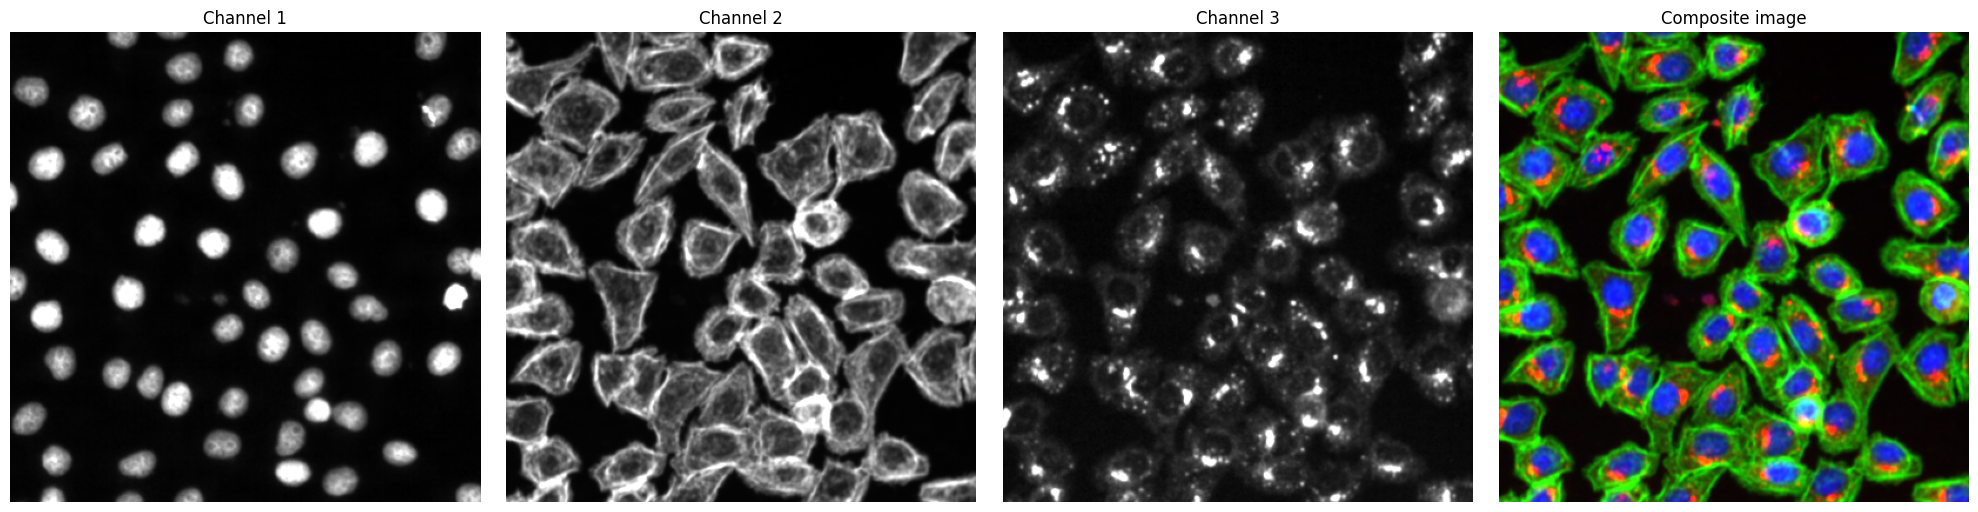

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from scportrait.data._datasets import dataset_3
from scportrait.plotting.vis import generate_composite

# define input images
path = dataset_3()
images = [
    f"{path}/Ch1.tif",
    f"{path}/Ch2.tif",
    f"{path}/Ch3.tif",
]

image = np.array([tifffile.imread(img) for img in images])


fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, _img in enumerate(image):
    axs[i].imshow(_img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Channel {i+1}")

# also plot and visualize input image
img = generate_composite(image)

axs[3].imshow(img)
axs[3].axis("off")
axs[3].set_title("Composite image")

fig.tight_layout()

## Prepare for execution of scPortrait workflow

Now lets create a directory where we will save the results from our scPortrait runs. 

In [2]:
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
import os
import h5py
import yaml
from IPython.display import Markdown


project_directory = "../example_projects/example_3/segmentation_workflows"

if not os.path.isdir(project_directory):
    os.makedirs(project_directory)

config_file = "../example_projects/example_3/config_example3.yml"


## Segment input image with different segmentation algorithms

### Workflow specific parameters are stored in config files

The specific behaviour of a segmentation workflow is determined by the parameters in the supplied config file that is used to initialize the project. While different segmentation methods each have unique parameters that are required for the selected segmentation algorithm, all workflows share some common keys and a common structure. You can read more about it [here](https://mannlabs.github.io/scPortrait/pages/workflow/segmentation_workflow.html#workflow-specific-parameters-are-stored-in-config-files). 


### different segmentation algorithms require a different number of input channels

To generate segmentation masks you will usually not require all of the channels present in your input images. In our example for instance only Channel 1 and Channel 2 are relevant for segmenting individual cells as they contain stains for the nucleus or plasma membrane respectively. 

The different segmentation workflows will automatically subset the provided input images to only run on the channels of interest. In some cases you may want to customize this behaviour e.g. because you want to use a maximum-intensity of multiple input channels as a proxy to perform segmentation on. You can find more details on this [here](https://mannlabs.github.io/scPortrait/pages/workflow/segmentation_workflow.html#input-channels-required-for-segmentation-algorithm). 


### WGA Segmentation

In [3]:
from scportrait.pipeline.segmentation.workflows import WGASegmentation

project_location = f"{project_directory}/WGASegmentation"

project = Project(
    os.path.abspath(project_location),
    config_path=config_file,
    overwrite=True,
    debug=False,
    segmentation_f=WGASegmentation,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_3/segmentation_workf
         lows/WGASegmentation/scportrait.sdata                                                                     


This segmentation workflow aims to segment mononucleated cells. Based on a nuclear and cytosolic stain, it first uses a thresholding approach to identify nuclei which are assumed to be the center of each cell. Then in a second step, the center of the identified nuclei are used as a starting point to generate a potential map using the cytosolic stain. This potential map is then used to segment the cytosol using a watershed approach. At the end of the workflow the user obtains both a nuclear and a cytosolic segmentation mask where each cytosol is matched to exactly one nucleus as kann be identified by the matching ``cell id``. 

The configuration file for the WGASegmentation method contains many parameters that need to be optimized for your particular dataset. 

Here is an example configuration:

In [4]:
display(Markdown(f"```yaml\n{yaml.dump(project.segmentation_f.config, default_flow_style=False)}\n```"))

```yaml
cache: .
chunk_size: 50
cytosol_segmentation:
  dilation: 7
  erosion: 2
  lower_quantile_normalization: 0.01
  max_clip: 0.2
  max_size: 30000
  min_clip: 0
  min_size: 200
  threshold: 0.15
  upper_quantile_normalization: 0.99
filter_masks_size: true
lower_quantile_normalization: 0.001
median_filter_size: 4
nucleus_segmentation:
  contact_filter: 0.5
  dilation: 0
  lower_quantile_normalization: 0.01
  max_size: 5000
  median_block: 41
  median_step: 4
  min_distance: 8
  min_size: 200
  peak_footprint: 7
  speckle_kernel: 9
  threshold: 0.2
  upper_quantile_normalization: 0.99
upper_quantile_normalization: 0.999

```

In [5]:
project.segment()
project.extract()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


#### Segmentation Results

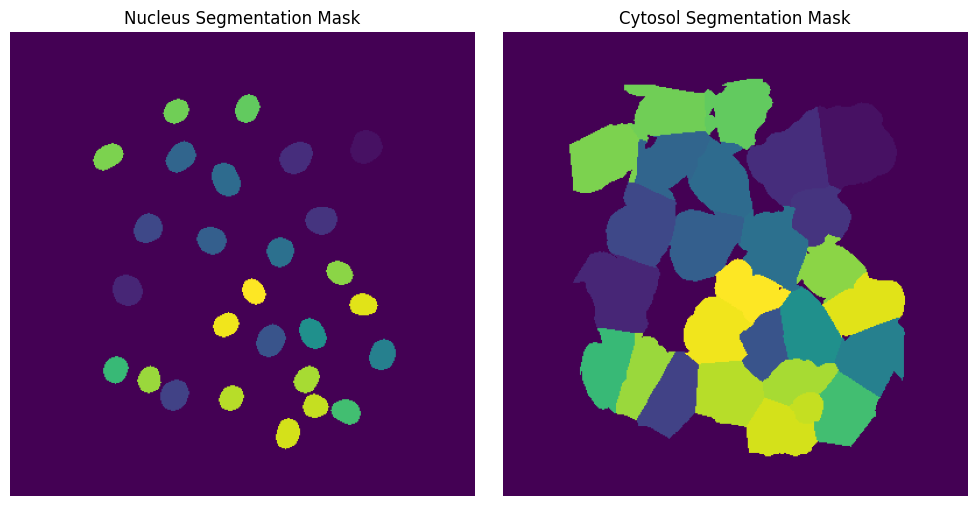

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(project.sdata["seg_all_nucleus"])
axs[0].axis("off")
axs[0].set_title("Nucleus Segmentation Mask")

axs[1].imshow(project.sdata["seg_all_cytosol"])
axs[1].axis("off")
axs[1].set_title("Cytosol Segmentation Mask")
fig.tight_layout()

#### Extraction Results

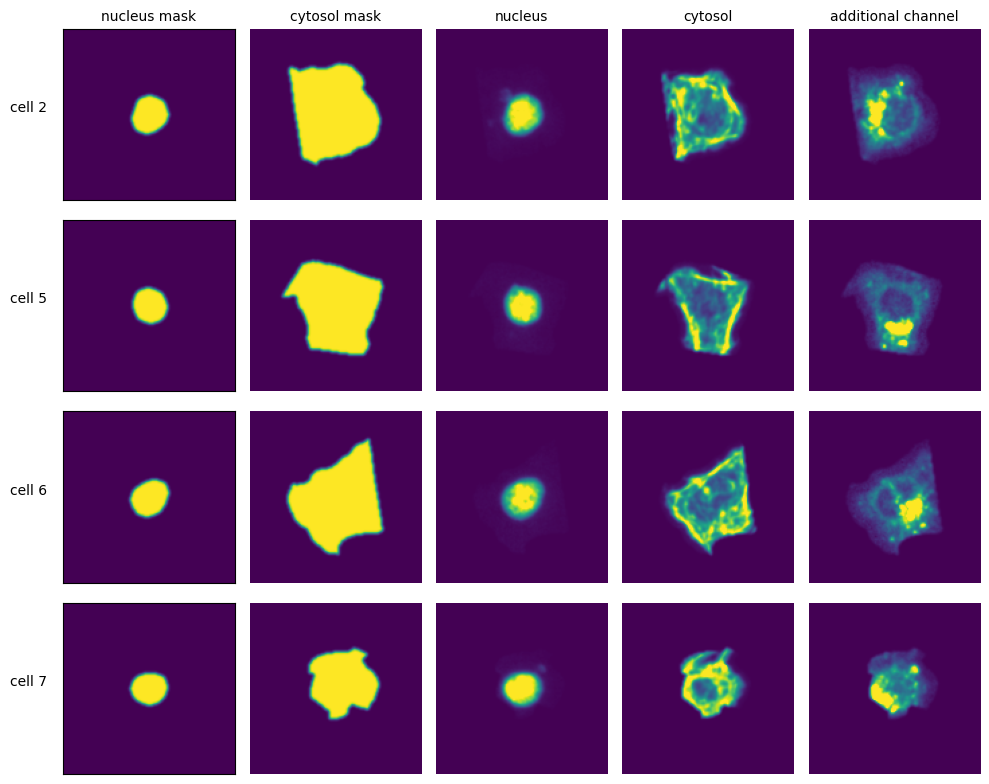

In [7]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize=(5 * 2, n_cells * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

### DAPI Segmentation

In [8]:
from scportrait.pipeline.segmentation.workflows import DAPISegmentation

project_location = f"{project_directory}/DAPISegmentation"

project = Project(
    os.path.abspath(project_location),
    config_path=config_file,
    overwrite=True,
    debug=False,
    segmentation_f=DAPISegmentation,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_3/segmentation_workf
         lows/DAPISegmentation/scportrait.sdata                                                                    


This segmentation workflow aims to only segment the nuclei of cells. It uses the same nuclear segmentation method as the WGASegmentation. 

Here is an example configuration:

In [9]:
display(Markdown(f"```yaml\n{yaml.dump(project.segmentation_f.config, default_flow_style=False)}\n```"))

```yaml
cache: .
chunk_size: 50
filter_masks_size: false
lower_quantile_normalization: 0.001
median_filter_size: 4
nucleus_segmentation:
  contact_filter: 0.5
  dilation: 0
  lower_quantile_normalization: 0.01
  max_size: 5000
  median_block: 41
  median_step: 4
  min_distance: 8
  min_size: 200
  peak_footprint: 7
  speckle_kernel: 9
  threshold: 0.2
  upper_quantile_normalization: 0.99
upper_quantile_normalization: 0.999

```

In [10]:
project.segment()
project.extract()

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


#### Segmentation Results

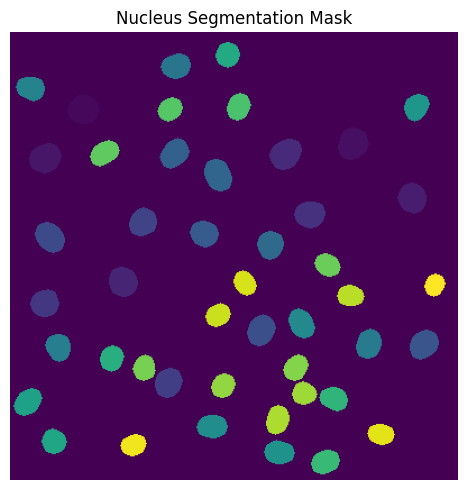

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(project.sdata["seg_all_nucleus"])
axs.axis("off")
axs.set_title("Nucleus Segmentation Mask")
fig.tight_layout()

#### Extraction Results

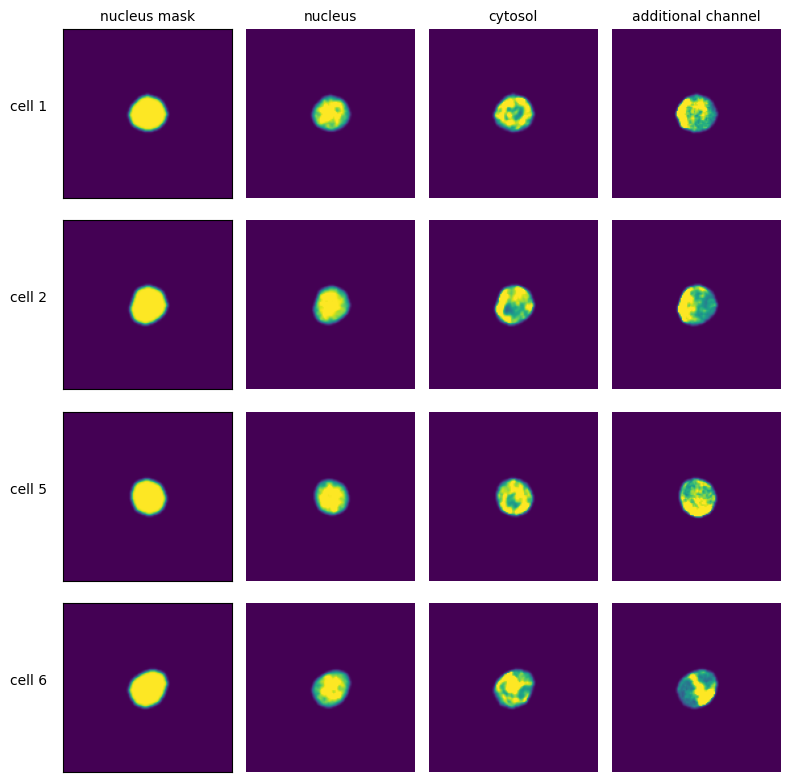

In [12]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 4, figsize=(4 * 2, n_cells * 2))
    labels = ["nucleus mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

### Cytosol Segmentation Cellpose

In [13]:
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose

project_location = f"{project_directory}/CytosolSegmentationCellpose"

project = Project(
    os.path.abspath(project_location),
    config_path=config_file,
    overwrite=True,
    debug=False,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_3/segmentation_workf
         lows/CytosolSegmentationCellpose/scportrait.sdata                                                         


This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow. During this segmentation workflow two different cellpose models are run. The first is used to segment the nuclei and the second one is used to segment the cytosols. Afterwards the IDs in the nucleus and cytosol mask are matched together.

Here is an example configuration:

In [14]:
display(Markdown(f"```yaml\n{yaml.dump(project.segmentation_f.config, default_flow_style=False)}\n```"))

```yaml
cache: .
cytosol_segmentation:
  model: cyto2
filter_masks_size: false
filtering_threshold_mask_matching: 0.95
match_masks: true
nucleus_segmentation:
  model: nuclei

```

In [15]:
project.segment()
project.extract()

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


#### Segmentation Results

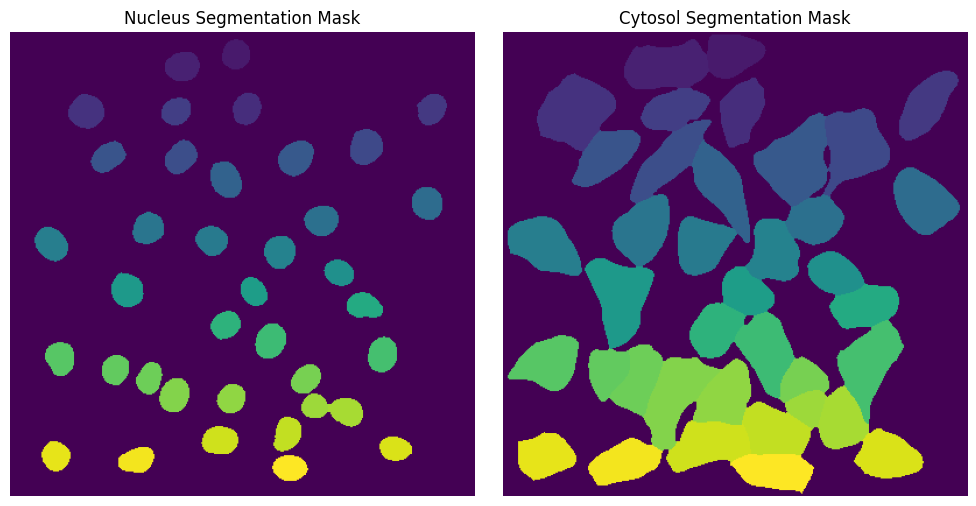

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(project.sdata["seg_all_nucleus"])
axs[0].axis("off")
axs[0].set_title("Nucleus Segmentation Mask")

axs[1].imshow(project.sdata["seg_all_cytosol"])
axs[1].axis("off")
axs[1].set_title("Cytosol Segmentation Mask")

fig.tight_layout()

#### Extraction Results

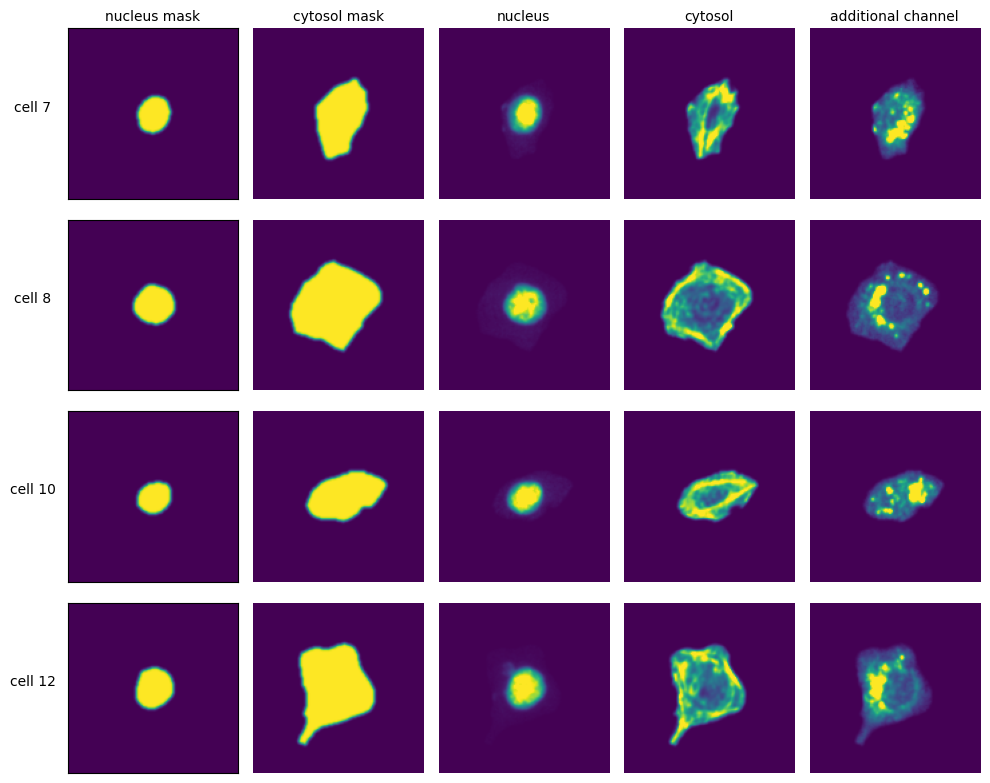

In [17]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 5, figsize=(5 * 2, n_cells * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

### DAPI Segmentation Cellpose

In [18]:
from scportrait.pipeline.segmentation.workflows import DAPISegmentationCellpose

project_location = f"{project_directory}/DAPISegmentationCellpose"

project = Project(
    os.path.abspath(project_location),
    config_path=config_file,
    overwrite=True,
    debug=False,
    segmentation_f=DAPISegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)
project.segment()
project.extract()

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_3/segmentation_workf
         lows/DAPISegmentationCellpose/scportrait.sdata                                                            


Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]



This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow. It only performs a nuclear segmentation using one cellpose model. 

Here is an example configuration:

In [19]:
display(Markdown(f"```yaml\n{yaml.dump(project.segmentation_f.config, default_flow_style=False)}\n```"))

```yaml
cache: .
filter_masks_size: false
nucleus_segmentation:
  model: nuclei

```

In [20]:
project.segment()
project.extract()

Extracting cell batches: 100%|██████████| 28/28 [00:00<00:00, 500.06it/s]


#### Segmentation Results

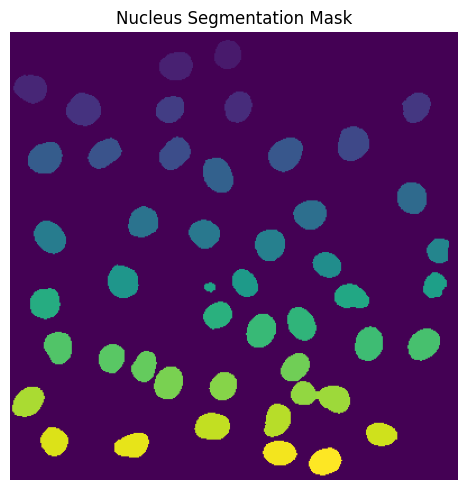

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(project.sdata["seg_all_nucleus"])
axs.axis("off")
axs.set_title("Nucleus Segmentation Mask")

fig.tight_layout()

#### Extraction Results

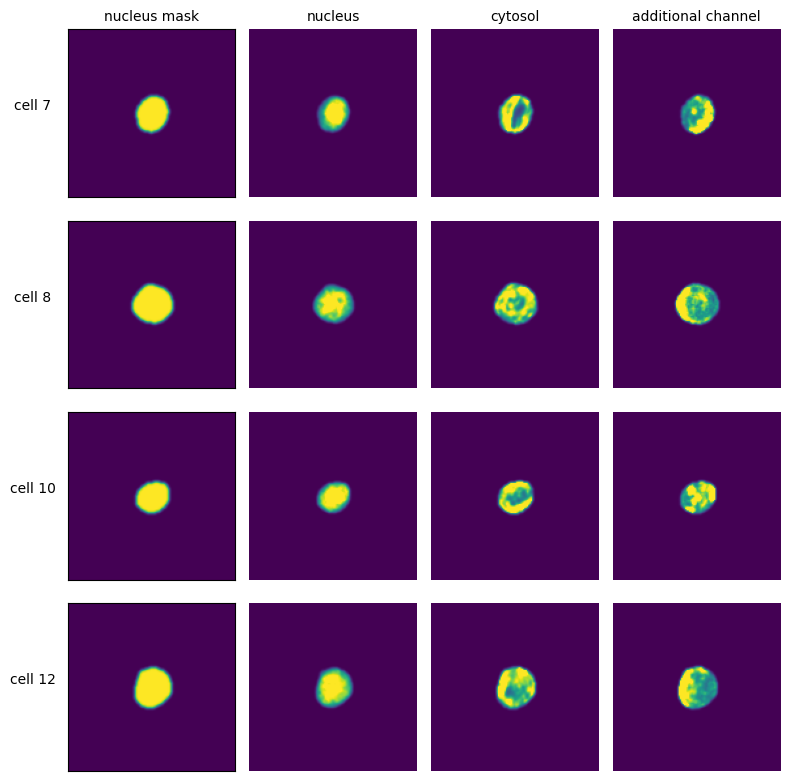

In [22]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 4, figsize=(4 * 2, n_cells * 2))
    labels = ["nucleus mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

### Cytosol Only Segmentation Cellpose

In [24]:
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose

project_location = f"{project_directory}/CytosolSegmentationCellpose"

project = Project(
    os.path.abspath(project_location),
    config_path=config_file,
    overwrite=True,
    debug=False,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_3/segmentation_workf
         lows/CytosolSegmentationCellpose/scportrait.sdata                                                         



This method uses a deep learning based segmentation approach and should optimally be run using a GPU as it is otherwise very slow. It only performs a cytosolic segmentation using one cellpose model but uses both a nuclear and a cytosolic image channel to generate the segmentation mask. See the [cellpose documentation](https://cellpose.readthedocs.io/en/latest/settings.html#channels) for more information

Here is an example configuration:

In [25]:
display(Markdown(f"```yaml\n{yaml.dump(project.segmentation_f.config, default_flow_style=False)}\n```"))

```yaml
cache: .
cytosol_segmentation:
  model: cyto2
filter_masks_size: false

```

In [26]:
project.segment()
project.extract()

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


#### Segmentation Results

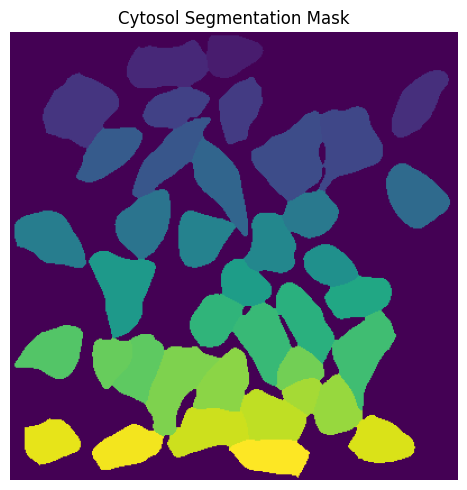

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(project.sdata["seg_all_cytosol"])
axs.axis("off")
axs.set_title("Cytosol Segmentation Mask")

fig.tight_layout()

#### Extraction Results

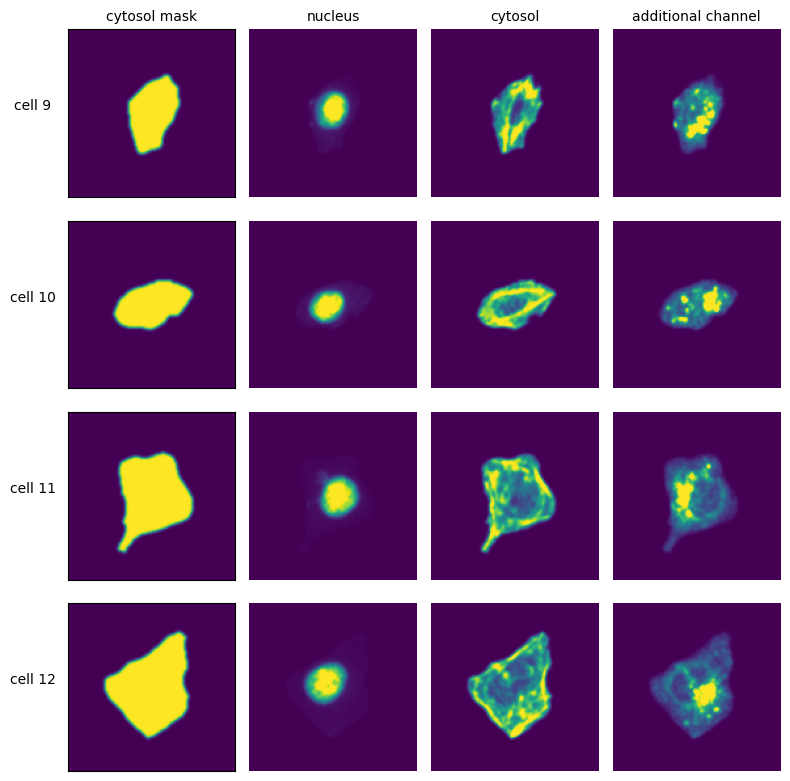

In [28]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 4, figsize=(4 * 2, n_cells * 2))
    labels = ["cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

### Using a custom cellpose model

In [29]:
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose

project_location = f"{project_directory}/CytosolSegmentationCellpose"

project = Project(
    os.path.abspath(project_location),
    config_path=config_file,
    overwrite=True,
    debug=False,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
)

project.load_input_from_tif_files(images)

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_3/segmentation_workf
         lows/CytosolSegmentationCellpose/scportrait.sdata                                                         


Now instead of using one of the pretrained models available in cellpose we want to segment the cells using our own custom trained model. 

Here we are going to download and use an example custom model provided with the scportrait code. Since the path to the downloaded file might not be identical on all systems we will dynamically update our config file after loading it but you could of course also change this directly in the config gile before loading.

In [30]:
from scportrait.data._datasets import custom_cellpose_model

custom_model_path = str(custom_cellpose_model())

project.config["CytosolOnlySegmentationCellpose"]["cytosol_segmentation"]["model_path"] = custom_model_path
project._update_segmentation_f(CytosolOnlySegmentationCellpose)

In [31]:
display(Markdown(f"```yaml\n{yaml.dump(project.segmentation_f.config, default_flow_style=False)}\n```"))

```yaml
cache: .
cytosol_segmentation:
  model: cyto2
  model_path: /Users/sophia/Documents/GitHub/scPortrait/src/scportrait/scportrait_data/custom_cellpose_model/custom_cellpose_model.cpkt
filter_masks_size: false

```

In [32]:
project.segment()
project.extract()

Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


#### Segmentation Results

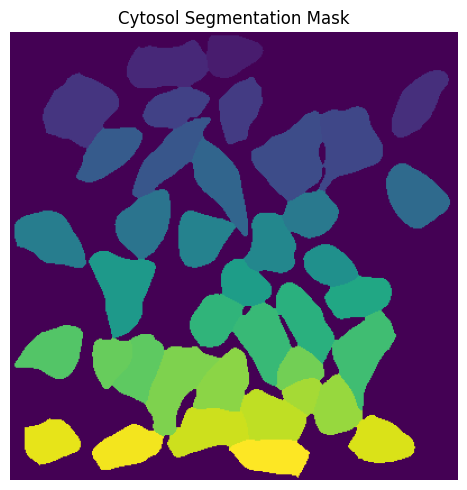

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(project.sdata["seg_all_cytosol"])
axs.axis("off")
axs.set_title("Cytosol Segmentation Mask")

fig.tight_layout()

#### Extraction Results

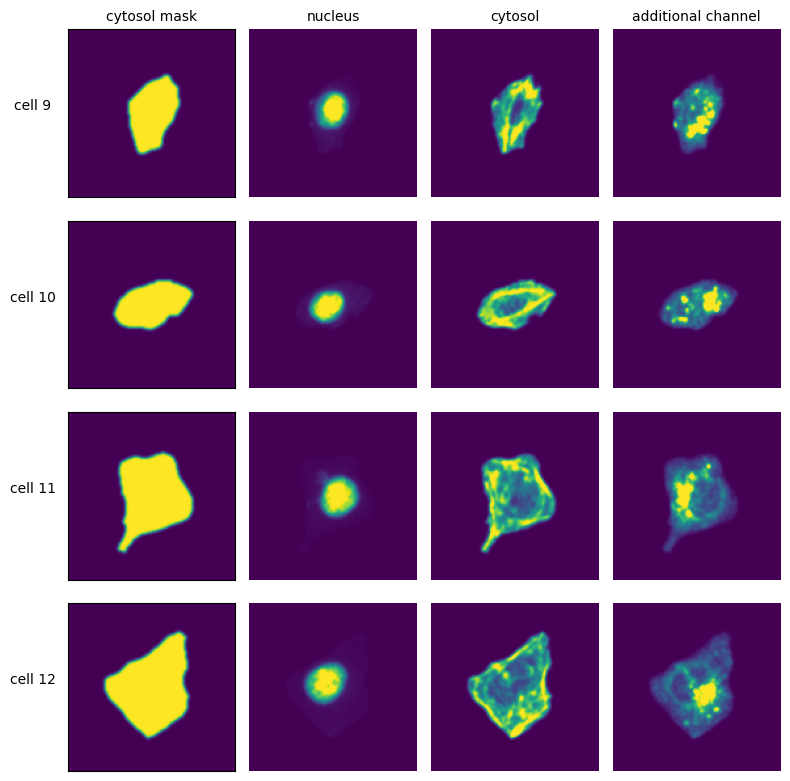

In [34]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    _images = hf.get("single_cell_data")

    n_cells = 4
    fig, axs = plt.subplots(n_cells, 4, figsize=(4 * 2, n_cells * 2))
    labels = ["cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i in range(n_cells):
        cell_id = index[i][1]
        image = _images[i]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()